In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('../dataset/')
from dataset import AsbestosDataSet

import os 
from pathlib import Path
import json
from pycocotools.coco import COCO
from PIL import Image
import cv2
from dataset import load_img
from utils import get_paths_from_dirs
from preprossesing import resize_images, transform_images, transform
import albumentations as A

In [21]:
5184/4,3456/4

(1296.0, 864.0)

In [22]:
resize_images(['/home/kirill/Учеба/asbestos/PitStonesData/asbestos_stone_lab_common_camera/SegmentationAsbest'],
              ['*'],
              '/home/kirill/Учеба/asbestos/PitStonesData/lab_common_camera_resize/segmentation/',
              (1296, 864), kwargs={'dtype1':np.float32,"c":2})

##Конверт

In [2]:
def create_annotation_mask(coco_set, img_indx, image_root, category_name = 'asbest'):
    cat_ids  = coco_set.getCatIds(catNms=[category_name])
    img_ids  = coco_set.getImgIds(catIds=cat_ids );
    image_dict = coco_set.loadImgs(img_indx)[0]
    ann_ids = coco_set.getAnnIds(imgIds=image_dict['id'], catIds=cat_ids, iscrowd=None)
    anns = coco_set.loadAnns(ann_ids)
    if len(anns) > 0:
        for i in range(len(anns)):
            if i == 0:
                mask = np.array(coco_set.annToMask(anns[0]), dtype = np.int64)
            else:
                mask += coco_set.annToMask(anns[i])

        mask[mask>1] = 1#for stones!
    else: 
        w = coco_set.loadImgs(1)[0]['width']
        h = coco_set.loadImgs(1)[0]['height']
        mask = np.zeros((h,w))
    return mask

In [3]:
#Create asbest segmentation from annotation file
def create_segmentation_from_annotation(coco_dataset, image_root, out_segmentation_root, category_name):
    for idx, image_name in coco_dataset.imgs.items():
        name = image_name['file_name'].split('/')[-1].split('.')[0]
        try:
            mask = create_annotation_mask(coco_dataset, idx, image_root, category_name)
            plt.imsave(os.path.join(out_segmentation_root, name + '.png'), mask, cmap='Greys')
        except Exception as err:
            print(idx, err)       
        if idx%10 == 0:
            print(idx)

In [4]:
coco_set = COCO('/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/annotations/instances_default.json')
# coco_set = COCO('/home/kirill/Учеба/asbestos/task_pits_stones_detections_111121-2021_12_03_05_40_57-coco 1.0/annotations/instances_default.json')
coco_set.dataset['categories']

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


[{'id': 1, 'name': 'stone', 'supercategory': ''},
 {'id': 2, 'name': 'asbest', 'supercategory': ''}]

### asbestos/task_pits_stones_detections_111121-2021_12_03_05_40_57-coco 1.0 

In [4]:
# coco_set = COCO('/home/kirill/Учеба/asbestos/task_pits_stones_detections_111121-2021_12_03_05_40_57-coco 1.0/annotations/instances_default.json')
print(coco_set.dataset['categories'])
image_path = '/home/kirill/Учеба/asbestos/task_pits_stones_detections_111121-2021_12_03_05_40_57-coco 1.0/images/'

mask = create_annotation_mask(coco_set, 52, image_path, category_name='asbest')
fig = plt.figure(dpi = 100)
plt.imshow(mask)

NameError: name 'coco_set' is not defined

In [12]:
segmentation_root = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/SegmentationAsbest'
segmentation_rock_root = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/SegmentationRock'
image_path = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/JPEGImages/'

In [13]:
create_segmentation_from_annotation(coco_set, image_path, segmentation_rock_root, 'asbest')

10
20
30
40
50


## lab_common_set

In [6]:
dir_image = "/home/kirill/Учеба/asbestos/PitStonesData/asbestos_stone_lab_common_camera/images/asbestos/stones/lab_common_camera/"
files = os.listdir(dir_image)

In [7]:
image = np.array(Image.open(Path(dir_image, files[5])))
image.shape

(5184, 3456, 4)

In [10]:
coco_set = COCO("/home/kirill/Учеба/asbestos/PitStonesData/asbestos_stone_lab_common_camera/annotations/instances_default.json")
coco_set.dataset['categories']

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


[{'id': 1, 'name': 'stone', 'supercategory': ''},
 {'id': 2, 'name': 'asbest', 'supercategory': ''}]

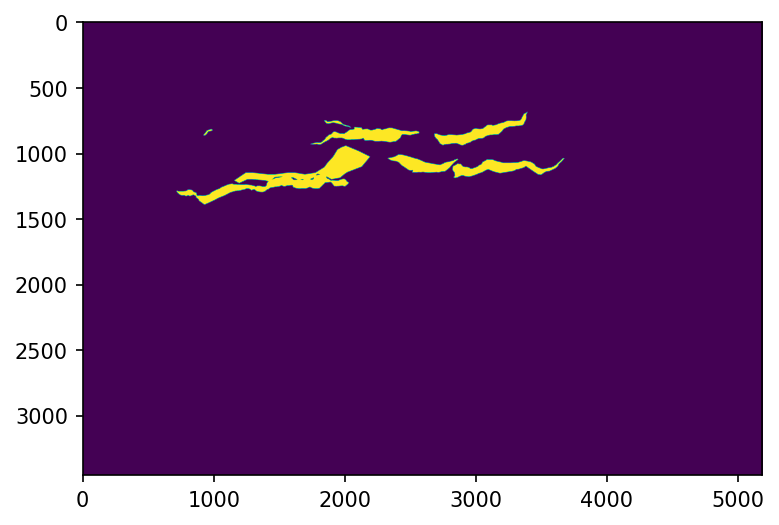

In [14]:
mask = create_annotation_mask(coco_set, 32, dir_image,'asbest')
fig = plt.figure(dpi = 150)
plt.imshow(mask)

In [17]:
segment_dir = '/home/kirill/Учеба/asbestos/PitStonesData/asbestos_stone_lab_common_camera/SegmentationAsbest'
create_segmentation_from_annotation(coco_set,dir_image, segment_dir, 'asbest')

10
20
30
40


In [14]:
image_dir = "../../PitStonesData/lab_common_test/image/"
mask_dir  = "../../PitStonesData/lab_common_test/segmentation/"
dataset = AsbestosDataSet(image_dir, mask_dir)

In [15]:
def rotate_image_mask(image_dict):
    image = image_dict['image']
    mask  = image_dict['mask']
    name  = image_dict['path']
    image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
    mask = cv2.rotate(mask, cv2.cv2.ROTATE_90_CLOCKWISE)
    mask = np.logical_not(mask).astype(np.long)
    return image, mask

In [16]:
for ex in dataset:
    shape = ex['image'].shape
    if shape[0] > shape[1]:
        image, mask = rotate_image_mask(ex)
        name = ex['path']
        
        plt.imsave(os.path.join(image_dir, name), image)
        plt.imsave(os.path.join(mask_dir, name), mask, cmap = 'Greys_r')
        print(ex['path'],' перевернут')
    else:
        mask = ex['mask']
        name = ex['path'].rename('png','jpg')
        mask = np.logical_not(mask).astype(int)
        plt.imsave(os.path.join(mask_dir, name), mask, cmap = 'Greys_r')
        print(ex['path'],' обработан')

AttributeError: 'str' object has no attribute 'rename'

In [3]:
### Резайз

In [18]:
resize_images(['/home/kirill/Учеба/asbestos/PitStonesData/asbestos_stone_lab_common_camera/images/asbestos/stones/lab_common_camera'],
              ['*'],
              '/home/kirill/Учеба/asbestos/PitStonesData/lab_common_camera_resize/images',
              (1728,1152), kwargs={''})

KeyboardInterrupt: 

In [4]:
transform = A.Compose([
    A.ToFloat(max_value=65535.0),
    A.RandomRotate90(),
    A.Flip(),
    A.ToFloat(max_value=65535.0),
])

transform_images(['/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/images/'],
                  ['*'],
                '/home/kirill/Учеба/asbestos/PitStonesData/48_test/',
                 transform,
                {'times':1}
                )

In [98]:
trans = A.Compose([
        A.ToFloat(max_value=255.0),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.Resize(1024,1024),
        A.FromFloat(max_value=255.0),
]
)

# transform("/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/images/",
#          "/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/segmentation/",
#          "/home/kirill/Учеба/asbestos/PitStonesData/48_test/",
#          trans, 
#         **{"times":3}
#          )


transform("/home/kirill/Учеба/asbestos/PitStonesData/lab_common_camera_resize/images/",
         "/home/kirill/Учеба/asbestos/PitStonesData/lab_common_camera_resize/segmentation/",
         "/home/kirill/Учеба/asbestos/PitStonesData/lab_common_test/",
         trans, 
        **{"times":3}
         )

3


In [61]:
p = '/home/kirill/Учеба/asbestos/PitStonesData/lab_common_camera_resize/images/IMG_2688.png'
img = load_img(p, int)

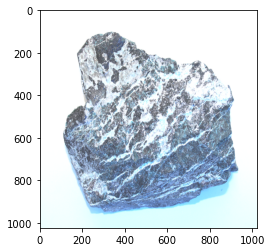

In [95]:
trans = A.Compose([
        A.ToFloat(max_value=255.0),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.Resize(1024,1024),
        A.FromFloat(max_value=255.0),
]
)
data = trans(image = img, mask = img)
plt.imshow(data['image'])

In [94]:
cv2.imwrite('l.png', data['image'])


TypeError: rename() missing 1 required positional argument: 'target'

In [73]:
paths = get_paths_from_dirs(['/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/segmentation'],['*'])

In [49]:
squares = np.zeros((len(paths),))
for i, p in enumerate(paths):
    img = load_img(p)
    res = img.mean(axis=2)
    res = res.astype(np.bool_)*1
    sqrt = (res.sum()/(res.shape[0]*res.shape[1]))*100
    squares[i] = sqrt

In [47]:
squares.mean()

7.873107508609169

In [50]:
squares.mean()

7.872752552557125